In [ ]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
import time, math, copy
from tqdm import tqdm
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import h5py
import numpy as np

In [ ]:
f = h5py.File("/content/gdrive/MyDrive/gamma.hdf5", 'r') 

In [ ]:
#plt.hist(energy, bins='auto')

In [ ]:
with h5py.File("/content/gdrive/MyDrive/gamma.hdf5", 'r') as f:
   energy = f['energy'][:]
   layer_0 = f['layer_0'][:]
   layer_1 = f['layer_1'][:]
   layer_2 = f['layer_2'][:]
   overflow = f['overflow'][:]

In [ ]:
f = h5py.File("/content/gdrive/MyDrive/eplus.hdf5", 'r') 

In [ ]:
with h5py.File("/content/gdrive/MyDrive/eplus.hdf5", 'r') as f:
   energy_ep = f['energy'][:]
   layer_0_ep = f['layer_0'][:]
   layer_1_ep = f['layer_1'][:]
   layer_2_ep = f['layer_2'][:]
   overflow_ep = f['overflow'][:]

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset, Subset

class CustomImageDataset(Dataset):
    def __init__(self, labels, layer_0, layer_1,layer_02):
        self.labels = labels
        self.layer_0 = layer_0 
        self.layer_1 = layer_1
        self.layer_2 = layer_2
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image1 = layer_0[idx]
        image2 = layer_1[idx]
        image3 = layer_2[idx]
        label = self.labels[idx]
        return (image1,image2,image3), label

In [ ]:
dataset_gamma = CustomImageDataset(np.ones(100000),layer_0,layer_1,layer_2)
dataset_ep = CustomImageDataset(np.zeros(100000),layer_0_ep,layer_1_ep,layer_2_ep)
total_data = torch.utils.data.ConcatDataset([dataset_gamma, dataset_ep])

In [ ]:
N = len(total_data)

# generate & shuffle indices
indices = np.arange(N)
indices = np.random.permutation(indices)
# there are many ways to do the above two operation. (Example, using np.random.choice can be used here too

# select train/test/val, for demo I am using 70,15,15
train_indices = indices [:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.85*N)]
test_indices = indices[int(0.85*N):]

train_dataset = Subset(total_data, train_indices)
val_dataset = Subset(total_data, val_indices)
test_dataset = Subset(total_data, test_indices)

In [ ]:
import torch 
from torch import nn


In [ ]:
def conv_block(input_size, output_size, kernel_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, kernel_size), nn.ReLU(), nn.BatchNorm2d(output_size), nn.MaxPool2d((1, 2)),
    )

    return block

In [ ]:
class network(nn.Module):
    
    def __init__(self,):
        super().__init__()
        
        self.input1 = conv_block(1,3,(1,3))
        self.input12 =  conv_block(3, 3, (3, 3))
        self.input2 = conv_block(1,3,(3, 3))
        self.input22 = conv_block(3,3,(3, 3))
        self.input3 = nn.Linear(12*6,10)
        
        
        self.bn1 = nn.BatchNorm1d(66)
        self.bn2 = nn.BatchNorm1d(24)
        self.bn3 = nn.BatchNorm1d(10)
        
        self.lin1 = nn.Linear(100,40)
        self.lin15 = nn.Linear(40,20)
        self.lin2 = nn.Linear(20,1)
        
        self.drop1 = nn.Dropout(p=0.2)
        self.drop2 = nn.Dropout(p=0.2)
        self.drop3 = nn.Dropout(p=0.2)

        self.activ = nn.ReLU()
        
    def forward(self,x,y,z):
        x = self.input1(x.reshape([16,1, 3, 96]).float())
        #print(x.shape)
        x = self.input12(x).flatten(start_dim=1)

        y = self.input2(y.reshape([16, 1, 12, 12]).float())
        y = self.input22(y)

        y = y.flatten(start_dim=1)
  
        z = self.activ(self.input3(z.flatten(start_dim=1)))
        
        h = torch.cat((self.drop1(self.bn1(x)), self.drop2(self.bn2(y)), self.drop3(self.bn3(z))),axis=1)
        
        h = self.activ(self.lin1(h))
        h =  self.activ(self.lin15(h))
        h = self.lin2(h)
        
        return h

In [ ]:
heh = network().to(device)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
dataloaders = {'train':DataLoader(train_dataset, batch_size=16),'val':DataLoader(val_dataset, batch_size=16), 'test':DataLoader(test_dataset, batch_size=16)}

In [ ]:
loss_fn = loss = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = torch.optim.SGD(heh.parameters(), lr=0.4)

In [ ]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, (data,labels) in enumerate(dataloaders['train']):
        # Every data instance is an input + label pair
        data0,data1,data2 = data
        data0,data1,data2 = data0.to(device),data1.to(device),data2.to(device)
       # print(torch.bincount(labels.type(torch.int)))
        labels = labels.to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = heh(data0.float(),data1.float(),data2.float())

        # Compute the loss and its gradients
        loss = loss_fn(outputs.float().squeeze(), labels.float())
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(dataloaders['train']) + i + 1
            running_loss = 0.

    return last_loss

In [ ]:
train_loss = []
val_loss = []

In [ ]:
EPOCHS = 30
epoch_number = 0

best_vloss = 1_00000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    heh.train(True)
    avg_loss = train_one_epoch(epoch_number)
    train_loss.append(avg_loss)
    # We don't need gradients on to do reporting
    heh.train(False)

    running_vloss = 0.0
    for i, (vdata,vlabels) in enumerate(dataloaders['val']):
        vdata0,vdata1,vdata2 = vdata
        vdata0,vdata1,vdata2 = vdata0.to(device),vdata1.to(device),vdata2.to(device)
        vlabels = vlabels.to(device)
        voutputs = heh(vdata0.float(),vdata1.float(),vdata2.float())
        vloss = loss_fn(voutputs.squeeze(), vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    val_loss.append(avg_vloss)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation


    # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(heh.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.6953238577246666
  batch 2000 loss: 0.6946346848011017
  batch 3000 loss: 0.6949235211014748
  batch 4000 loss: 0.6950234887599945
  batch 5000 loss: 0.695378478884697
  batch 6000 loss: 0.6946329537034035
  batch 7000 loss: 0.694698725938797
  batch 8000 loss: 0.6948249584436417
LOSS train 0.6948249584436417 valid 0.6931475988490663
EPOCH 2:
  batch 1000 loss: 0.6948966245651245
  batch 2000 loss: 0.6945847621560097
  batch 3000 loss: 0.6948951486349105
  batch 4000 loss: 0.6949359941482544
  batch 5000 loss: 0.6953784912824631
  batch 6000 loss: 0.6946191759109497
  batch 7000 loss: 0.6947209784984588
  batch 8000 loss: 0.6948261606097221
LOSS train 0.6948261606097221 valid 0.6931565049224223
EPOCH 3:
  batch 1000 loss: 0.6948967332839966
  batch 2000 loss: 0.6945813648104667
  batch 3000 loss: 0.6948873528838158
  batch 4000 loss: 0.6949934104084968
  batch 5000 loss: 0.6953602090477944
  batch 6000 loss: 0.6945862766504288
  batch 7000 loss: 0.69471435

In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(heh)

In [ ]:
predicts = []
real = []
for i, (vdata,vlabels) in enumerate(dataloaders['test']):
        vlabels = vlabels.to(device)
        vdata0,vdata1,vdata2 = vdata
        vdata0,vdata1,vdata2 = vdata0.to(device),vdata1.to(device),vdata2.to(device)
        voutputs = heh(vdata0.float(),vdata1.float(),vdata2.float())
        voutputs = torch.nn.functional.sigmoid(voutputs)
        pred = voutputs > 0.5
        pred = 1 * pred
        running_vloss += vloss
        for i in pred:
            predicts.append(i.item())
        for i in vlabels:
            real.append(i.item())

from sklearn.metrics import accuracy_score

In [ ]:
print(accuracy_score(real,predicts))

0.4975333333333333


In [ ]:
import matplotlib.pyplot as plt

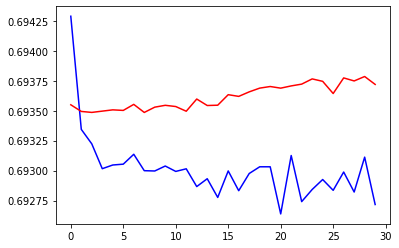

In [ ]:
plt.plot(train_loss, c = 'blue')
plt.plot([i.item() for i in val_loss], c = 'red')